**Load the Cleaned Dataset & Prepare for SVM Training**

Import the Reuired Libraries

In [114]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#Visualize the Performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import os

Load Cleaned Dataset

In [115]:
#Load Cleaned Dataset
df=pd.read_csv("Data/processed/FC110543_SarasiPerera/clean_dataset.csv")


#Check shape and preview
print("Loaded dataset shape:",df.shape)
df.head()

Loaded dataset shape: (27819, 14)


,gender,age,profession,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work_study_hours,financial_stress,family_history_of_mental_illness,depression
0,Male,33.0,Student,5.0,8.97,2.0,NaN,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Student,2.0,5.90,5.0,NaN,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Student,3.0,7.03,5.0,NaN,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Student,3.0,5.59,2.0,NaN,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Student,4.0,8.13,3.0,NaN,Moderate,M.Tech,Yes,1.0,1.0,No,0


Encode the Target Variable

In [116]:
#Use LabelEncoder to convert the target variable to numeric
le=LabelEncoder()
df['depression']=le.fit_transform(df['depression'])  # 0-No Depression,1-Depression


Split the Data (Before Encoding/Scaling)

In [117]:
#Separate features and target
X=df.drop(columns='depression')
y=df['depression']

# Train-test split (Best practice: do this before encoding and scaling)
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)

print("Train shape:",X_train.shape)
print("Test shape:",X_test.shape)


Train shape: (22255, 13)
Test shape: (5564, 13)


Apply Label Encoding to Categorical Columns

In [118]:
#Identify categorical features
categorical_cols=X.select_dtypes(include='object').columns.tolist()
print("Categorical Columns to Encode:",categorical_cols)

# Use OneHotEncoder for nominal categorical variables
# drop='first' to avoid multicollinearity
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave numeric columns as-is
)

# Fit on train, transform both train and test (Best practice)
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

Categorical Columns to Encode: ['gender', 'profession', 'dietary_habits', 'degree', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Impute missing values (mean for numeric)

In [119]:
# Create imputer (using mean strategy for numeric columns)
imputer = SimpleImputer(strategy='mean')

# Fit imputer on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

/usr/local/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [47]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Scale Features

In [120]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler with with_mean=False due to sparse matrix input
scaler = StandardScaler(with_mean=False)

# Fit on training data, transform both sets
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


#Train the SVM model

In [121]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Visualize Performance

*Help to interpret how the model is performing.*

*In here, I evaluated the trained SVM model using test data. Created a confusion matrix to assess the model's prediction performance. The matrix shows the number of true positives,false positives,true negatives and false negatives. They help us to understand how well the model classifies depression cases.*

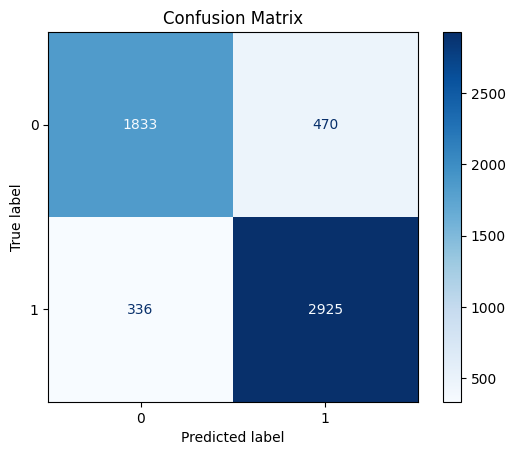

In [122]:
#Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Save Artifacts

*In here, I saved the essential components of the trained SVM pipeline for future use or deployment. So, we can later use the exact same preprocessing and scaling setup when making predictions on new data.*

In [123]:
import joblib
#Save scaler and preprocessor (optional but useful for deployment)
joblib.dump(scaler,"models/scaler.joblib")
joblib.dump(preprocessor,"models/preprocessor.joblib")


['models/preprocessor.joblib']

Perform Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores=cross_val_score(svm_model,X_train_scaled,y_train, cv=5)
print("Cross-Validation Scores:",cv_scores)
print("Mean CV Accuracy:",np.mean(cv_scores))

Cross-Validation Scores: [0.8496967  0.84385531 0.82385981 0.84992137 0.85126938]
Mean CV Accuracy: 0.8437205122444394


Evaluate Model Predictions in Detail

In [126]:
#Predict on test set
y_pred=svm_model.predict(X_test_scaled)

#Accuracy
print("Test Accuracy:",accuracy_score(y_test, y_pred))

#Detailed classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Depression","Depression"]))


Test Accuracy: 0.8551401869158879
Classification Report:

               precision    recall  f1-score   support

No Depression       0.85      0.80      0.82      2303
   Depression       0.86      0.90      0.88      3261

     accuracy                           0.86      5564
    macro avg       0.85      0.85      0.85      5564
 weighted avg       0.85      0.86      0.85      5564



Hyperparameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

#Define parameter grid
param_grid={
    'C':[0.1, 1, 10],
    'kernel':['linear','rbf','poly'],
    'gamma':['scale','auto']
}

# Initialize grid search
grid_search=GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#Fit on training data
grid_search.fit(X_train_scaled, y_train)

#Display results
print("Best Parameters:",grid_search.best_params_)
print("Best Cross-Validation Accuracy:",grid_search.best_score_)
